In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
!pip install -q transformers
!pip install -q sentencepiece

In [6]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def read_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

In [9]:
def ocr(image, processor, model):
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [10]:
def eval_new_data(data_path=None, num_samples=4, model=None):
  image_paths = glob.glob(data_path)
  for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):

    if i == num_samples:
      break
    image = read_image(image_path)
    text = ocr(image, processor, model)
    plt.figure(figsize=(7, 4))
    plt.imshow(image)
    plt.title(text)
    plt.axis('off')
    plt.show()

In [11]:
from IPython.display import clear_output
clear_output()

In [12]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
before_trained = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-base-handwritten'
).to(device)

clear_output()

In [13]:
# eval_new_data(
#     data_path="/content/drive/MyDrive/Data/TestImages/demo8.jpg",
#     num_samples=4,
#     model=before_trained
# )

In [14]:
# import cv2
# import numpy as np
# import pandas as pd
# import os
# import random

# # Define paths
# image_folder = "/content/drive/MyDrive/Data/Images"  # Folder containing images
# csv_path = "/content/drive/MyDrive/Data/text_images.csv"   # CSV file path
# output_folder = "/content/drive/MyDrive/Data/Images"  # Folder to save concatenated images

# # Create output folder if not exists
# os.makedirs(output_folder, exist_ok=True)

# # Load CSV file, handling potential NaN values in 'file_name'
# df = pd.read_csv(csv_path)
# df = df.dropna(subset=['file_name'])  # Remove rows with NaN in 'file_name' column

# # Convert CSV to dictionary {image_name: label}
# image_label_dict = dict(zip(df["file_name"], df["text"]))

# # Get all image file names
# image_files = list(image_label_dict.keys())

# # Shuffle for randomness (optional)
# #random.shuffle(image_files) # Removed to prevent further issues for testing

# # Store new image data
# new_entries = []

# # Process images in pairs
# for i in range(0, len(image_files) - 1, 2):  # Step of 2
#     img1_name, img2_name = image_files[i], image_files[i + 1]

#     # Load images, using the output folder in case of existing concatenated image
#     img1_path = os.path.join(output_folder, img1_name)  # Check output folder first
#     if not os.path.exists(img1_path):
#         img1_path = os.path.join(image_folder, img1_name)  # Fallback to original folder
#     img1 = cv2.imread(img1_path)

#     img2_path = os.path.join(output_folder, img2_name) #Check output folder first
#     if not os.path.exists(img2_path):
#         img2_path = os.path.join(image_folder, img2_name)  # Fallback to original folder
#     img2 = cv2.imread(img2_path)


#     # Check if images loaded successfully
#     if img1 is None:
#         print(f"Warning: Could not load image {img1_path}")
#         continue  # Skip to the next pair
#     if img2 is None:
#         print(f"Warning: Could not load image {img2_path}")
#         continue  # Skip to the next pair

#     # Ensure both images have the same height
#     if img1.shape[0] != img2.shape[0]:
#         img2 = cv2.resize(img2, (img2.shape[1], img1.shape[0]))

#     # Concatenate horizontally
#     concatenated_image = np.hstack((img1, img2))

#     # New image name
#     new_image_name = f"concat_{img1_name.split('.')[0]}_{img2_name.split('.')[0]}.jpg"
#     new_image_path = os.path.join(output_folder, new_image_name)

#     # Save concatenated image
#     cv2.imwrite(new_image_path, concatenated_image)

#     # Get combined label
#     new_label = f"{image_label_dict[img1_name]} {image_label_dict[img2_name]}"

#     # Store new entry
#     new_entries.append({"file_name": new_image_name, "text": new_label})

# # Convert new data to DataFrame
# new_df = pd.DataFrame(new_entries)

# # Append new data to original CSV
# df = pd.concat([df, new_df], ignore_index=True)

# # Save updated CSV
# df.to_csv(csv_path, index=False)

# print(f"Concatenation completed! Images saved in '{output_folder}' and CSV updated.")

In [15]:
from torch.utils.data import Dataset, DataLoader

In [16]:
train_df = pd.read_csv("/content/drive/MyDrive/Data/text_images.csv", header=None, names=['file_name', 'text'],usecols=[0,1],skiprows=1)
validation_df = pd.read_csv("/content/drive/MyDrive/Data/text_images.csv", header=None, names=['file_name', 'text'],usecols=[0,1],skiprows=1)

In [17]:
train_df.tail()

,file_name,text
109,concat_concat_34_35_concat_36_concat_0_1.jpg,"everyone the under quirky lake ,"
110,concat_concat_concat_2_3_concat_4_5_concat_con...,a moon . fox lazy through glowing dog . The
111,concat_concat_concat_10_11_concat_12_13_concat...,dozen Jack jogged and broken over brown While
112,concat_concat_concat_18_19_concat_20_21_concat...,amazed quickly lamps zebras zigzagging streets...
113,concat_concat_concat_26_27_concat_28_29_concat...,busy by words Victor danced the near quick


In [18]:
import numpy as np
import cv2

In [19]:
def preprocess_image(image):
  image = np.array(image)

  if len(image.shape) == 2:
      # Check if image is grayscale
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)

  # Unsharp Masking: Enhance Edges
  sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
  binary = cv2.adaptiveThreshold(sharpened, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
  binary = cv2.bitwise_not(binary)
  kernel = np.ones((2, 2), np.uint8)
  denoised = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
  denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
  edges = cv2.Canny(denoised, 50, 150)
  final_image = cv2.resize(denoised, (384, 384), interpolation=cv2.INTER_AREA)
  if len(final_image.shape) == 2:
    final_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2RGB)  # Convert to RGB (3 dimensions)
  return final_image

In [20]:
# 1. Fixed Dataset Class
class OCRDataset(Dataset):
  def __init__(self, image_dir, df, processor, max_target_length=64):
    self.image_dir = image_dir
    self.processor = processor
    self.max_target_length = max_target_length
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx, 0]
    text = self.df.iloc[idx, 1]

    # Load image
    image_path = os.path.join(self.image_dir, img_name)
    try:
        image = Image.open(image_path).convert("RGB")
        processed_image = preprocess_image(image)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        raise

    # Process image and text separately
    pixel_values = self.processor.feature_extractor(
        processed_image,
        return_tensors="pt"
    ).pixel_values.squeeze(0)

    labels = self.processor.tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        max_length=self.max_target_length,
        truncation=True
    ).input_ids.squeeze(0)

    return {
        'pixel_values': pixel_values,
        'labels': labels              # Shape: [max_length]
    }

In [21]:
# 2. Data Collator
class TrOCRDataCollator:
  def __init__(self, processor):
    self.processor = processor


  def __call__(self, batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])

    # Create decoder inputs by shifting labels right
    decoder_input_ids = labels.clone()
    decoder_input_ids[:, 1:] = labels[:, :-1]
    decoder_input_ids[:, 0] = self.processor.tokenizer.cls_token_id

    return {
        "pixel_values": pixel_values,
        "labels": labels,
        "decoder_input_ids": decoder_input_ids,
        #"attention_mask": (decoder_input_ids != self.processor.tokenizer.pad_token_id).int()
    }

In [22]:
# Configure model
before_trained.config.decoder_start_token_id = processor.tokenizer.cls_token_id
before_trained.config.pad_token_id = processor.tokenizer.pad_token_id
before_trained.config.vocab_size = before_trained.config.decoder.vocab_size

In [23]:
# 4. Create Datasets
train_dataset = OCRDataset(
    image_dir="/content/drive/MyDrive/Data/Images",
    df=train_df,
    processor=processor
)

val_dataset = OCRDataset(
    image_dir="/content/drive/MyDrive/Data/Images",
    df=validation_df,
    processor=processor
)


In [24]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments,DataCollatorForSeq2Seq

In [25]:
# 5. Training Configuration
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    predict_with_generate=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    weight_decay=0.01,
)


In [26]:
# 6. Create Trainer
trainer = Seq2SeqTrainer(
    model=before_trained,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=TrOCRDataCollator(processor),
    tokenizer=processor,
)

<ipython-input-26-56902707cc7c>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [27]:
print(train_dataset)

In [28]:
# 7. Verify Data Loading
print("\nVerifying first training sample:")
sample = train_dataset[0]
print("Pixel values shape:", sample["pixel_values"].shape)
print("Labels shape:", sample["labels"].shape)

print("\nVerifying batch creation:")
sample_batch = trainer.data_collator([train_dataset[i] for i in range(2)])
print("Batch shapes:")
print({k: v.shape for k, v in sample_batch.items()})


Verifying first training sample:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([64])

Verifying batch creation:
Batch shapes:
{'pixel_values': torch.Size([2, 3, 384, 384]), 'labels': torch.Size([2, 64]), 'decoder_input_ids': torch.Size([2, 64])}


/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [29]:
# # 8. Start Training
# print("\nStarting training...")
# trainer.train()

In [30]:
model_path = "/content/drive/MyDrive/Data/Trained_model/troct-finetuned"

# model.save_pretrained(model_path)
# processor.save_pretrained(model_path)

In [31]:
processor = TrOCRProcessor.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)
clear_output()

  0%|          | 0/1 [00:00<?, ?it/s]

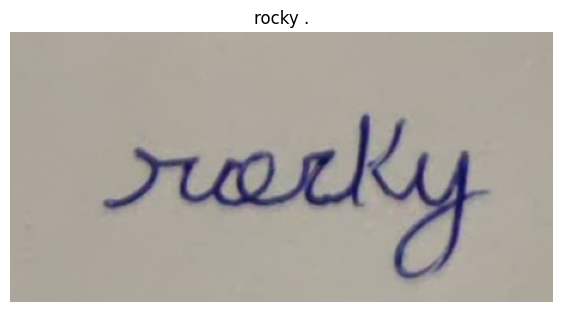

In [35]:
eval_new_data(
    data_path="/content/drive/MyDrive/Data/TestImages/demo7.jpg",
    num_samples=4,
    model=model
)